## Example Notebook Clustering Geo-Data Cubes

In this example notebook, we use the `Clustering Geo-Data Cubes` module (`cgc`) to perform a co-clustering analysis for a small subset of the first-bloom spring-index data from [Emma Izquierdo-Verdiguier, Raúl Zurita-Milla and Toby R. Ault, Mark D. Schwartz, Agricultural and Forest Meteorology 262, 34-41 (2018)](https://doi.org/10.1016/j.agrformet.2018.06.028) (please cite the reference if you use the data). The spatial extend has been cropped to be 700x700 pixel large, while we consider the full time span of the data (40 years). After co-clustering, we use k-means clustering to refine the analysis and reduce the number of clusters.

NOTE: This notebook makes use of [GDAL](https://gdal.org), run the following block to install it using `conda`:

In [8]:
# !conda install gdal -c conda-forge -y

In [9]:
import logging
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
import cgc
import dask.array as da
import json
import hashlib

from pathlib import Path
from osgeo import gdal
from dask.distributed import Client
from cgc.kmeans import Kmeans
from cgc.coclustering import Coclustering

print('CGC version: {}'.format(cgc.__version__))

CGC version: 0.4.0


### Set up the processing

Below are the manual inputs for the processing. They are divided into four parts:

1. Project related inputs
2. Input data related inputs
3. Co-clustering processing related arguments
4. K-means processing related arguments

For part `2` and `3` we cache the corresponding results according to the inputs, i.e., if the inputs do not change, no new computation will be performed.

In [10]:
# Project related
project_name = 'Bloom_CONUS' # dataset name, region name
dir_output = Path('./demo_output') # output data directory

# Input data 
dir_tiff = Path('./demo_data') # path to the tiff files
load_pattern = '*.tif' # bash glob pattern of the tiff files to load
band_id = 0 # band id to load. If the input tiff only has one band, this value will be ignored

# Co-clustering
## Changing the following inputs will start a new coclustering processing
k = 10  # num clusters in rows
l = 5  # num clusters in columns
niters = 20
errobj, epsilon = 1e-5, 10e-8
cache_id = '' # change the cache id to force a new processing
## Changing the following inputs won't start a new coclustering processing
n_batch = 1 # total number of batches
nruns_per_batch = 16 # number of runs per batch, this depends on the available memory
mode = 'dask' # choose 'dask' or 'numpy'
client = Client() # client for dask, will be ignored if mode == 'numpy'
nthreads_numpy = 4 # number of threads for numpy run, will be ignored if mode == 'dask'
low_memory = True # low memory processing flag
numba_jit = False # numba acceleration flag, will be ignored if mode == 'dask', or if low_memory == False

# Kmeans
kmean_max_iter = 500 # max number of iterations of kmean
k_range = range(2,25) # searching range of value "k"
variance_threshold = 1.2 # threshold of variance to select "k". Check the L-curve plot and readjust this value to select the optimal "k"

/home/ouku/miniconda3/envs/cgc/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37611 instead
  warnings.warn(


### Setup environment
After manual configuration, we setup three folders in `dir_output`:

1. `cache`: cache data storage. Intermediate results of data loading and co-clustering
2. `log`: log files
3. `results`: generated plots

In [11]:
# input cache
hash_input = hashlib.sha256()
for args in (dir_tiff,load_pattern,band_id):
    hash_input.update(str(args).encode('utf-8'))
hash_input = hash_input.hexdigest()[:7]
print('Input data caching ID: {}'.format(hash_input))

# coclustering cache
hash_cc = hashlib.sha256()
for args in (k,l,errobj,niters,epsilon,cache_id):
    hash_cc.update(str(args).encode('utf-8'))
hash_cc = hash_cc.hexdigest()[:7]
print('CoClustering caching ID: {}'.format(hash_cc))

# logging
timestamp = '{}'.format(time.strftime('%Y%m%d%H%M%S',time.localtime()))
print('Time stamp: {}'.format(timestamp))


# Path
logdir = (dir_output/'log')
resultdir = (dir_output/'results'/('results_{}').format(timestamp))
cachedir = (dir_output/'cache')
resultdir.mkdir(parents=True, exist_ok=True)
logdir.mkdir(parents=True, exist_ok=True)
cachedir.mkdir(parents=True, exist_ok=True)

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                    level=logging.INFO,
                    handlers=[logging.FileHandler(logdir/('{}_{}.log'.format(project_name,timestamp)), mode='w'),
                              logging.StreamHandler(stream=sys.stdout)])

Input data caching ID: 4efbed1
CoClustering caching ID: d15c097
Time stamp: 20210912231859


### Data loading
We loaded data from `dir_tiff`. The loaded tiff files will be specified by `load_pattern`, e.g. `*.tif` means all the tiffs. We assume all tiff files have the same dimension.

In [12]:
# Load all the geotiffs
fname = cachedir/('{}_Z_{}.npy'.format(project_name, hash_input))
if not fname.exists():
    h_tif = gdal.Open(dir_tiff.as_posix() +'/{}'.format(sorted(dir_tiff.glob(load_pattern))[0].name))
    band_flag = True
    if h_tif.RasterCount==1:
        band_flag = False
    Z = np.empty((h_tif.RasterXSize*h_tif.RasterYSize,0))
    for f_tiff in sorted(dir_tiff.glob(load_pattern)):
        print('loading {}'.format(f_tiff))
        h_tif = gdal.Open(f_tiff.as_posix())
        if band_flag:
            img = h_tif.ReadAsArray(0, 0, h_tif.RasterXSize, h_tif.RasterYSize)[band_id]
        else:
            img = h_tif.ReadAsArray(0, 0, h_tif.RasterXSize, h_tif.RasterYSize)
        img = img.reshape(-1, 1)
        Z = np.append(Z, img, axis=1)
    Z = Z.astype('float64')
    print('Saving loaded tiffs to: {}'.format(fname.as_posix()))
    np.save(fname, Z)
else:
    print('loading cached data: {}'.format(fname.as_posix()))
    Z = np.load(fname)

loading cached data: demo_output/cache/Bloom_CONUS_Z_4efbed1.npy


### Applying mask

Mask out the pixel if there is a NaN value in its time series.

In [13]:
# Mask out if there is nan in a row
mask = np.where(np.isnan(np.sum(Z, axis=1))==False)[0]

# Apply mask
Znp = Z[mask, :]
del Z

assert ~np.any(np.sum(np.isnan(Znp), axis=0))

### Co-clustering

In [14]:
# Co-clustering
fname = cachedir/'./{}_coclustering_{}.json'.format(project_name, hash_cc)
if not fname.exists():
    for b in range(n_batch):
        if mode == 'dask':
            Z = da.from_array(Znp) 
            Z = client.persist(Z)
            cc = Coclustering(Z, k, l, errobj, niters, nruns_per_batch, epsilon, output_filename=fname.as_posix())
            cc.run_with_dask(client, low_memory=low_memory)
            client.close()
        elif mode == 'numpy':
            cc = Coclustering(Znp, k, l, errobj, niters, nruns_per_batch, epsilon, output_filename=fname.as_posix())
            cc.run_with_threads(nthreads=nthreads_numpy, low_memory=low_memory, numba_jit=numba_jit)
    row_clusters = np.array(cc.results.row_clusters)
    col_clusters = np.array(cc.results.col_clusters)
else:
    with open(fname, 'r') as f:
        print('loading cached data: {}'.format(fname.as_posix()))
        data = json.load(f)
    row_clusters = np.array(data['row_clusters'])
    col_clusters = np.array(data['col_clusters'])


2021-09-12 23:19:00,187 | INFO : Run 0
2021-09-12 23:19:11,502 | INFO : Error = -6062988928.271701
2021-09-12 23:19:11,504 | WARNING : Run not converged in 20 iterations
2021-09-12 23:19:11,541 | INFO : Run 1
2021-09-12 23:19:22,211 | INFO : Error = -6063090630.073959
2021-09-12 23:19:22,222 | WARNING : Run not converged in 20 iterations
2021-09-12 23:19:22,283 | INFO : Run 2
2021-09-12 23:19:30,908 | INFO : Error = -6062543100.110454
2021-09-12 23:19:30,911 | WARNING : Run not converged in 20 iterations
2021-09-12 23:19:30,913 | INFO : Run 3
2021-09-12 23:19:39,078 | INFO : Error = -6065523747.789352
2021-09-12 23:19:39,090 | WARNING : Run not converged in 20 iterations
2021-09-12 23:19:39,129 | INFO : Run 4
2021-09-12 23:19:47,424 | INFO : Error = -6065030829.442479
2021-09-12 23:19:47,427 | WARNING : Run not converged in 20 iterations
2021-09-12 23:19:47,428 | INFO : Run 5
2021-09-12 23:19:56,528 | INFO : Error = -6065060095.442359
2021-09-12 23:19:56,530 | WARNING : Run not converg

### K-means
We search the optimal value of "k" within the range `k_range` with a variance threshold `var_thres`. The largest "k" which gives the variance smaller than `var_thres` will be selected. One may need to check the elbo (L-shaped) plot and manually adjust `var_thres` to select the optimal "k" value.

In [17]:
# Kmean
km = Kmeans(Z=Znp,
            row_clusters=row_clusters,
            col_clusters=col_clusters,
            n_row_clusters=k,
            n_col_clusters=l,
            kmean_max_iter=kmean_max_iter)
km.compute()

print(km.results.k_value)
print(km.results.measure_list)

/mnt/c/Users/OuKu/Developments/phenology/cgc/cgc/kmeans.py:180: RuntimeWarning: invalid value encountered in true_divide
  self.stat_measures_norm = np.divide((self.stat_measures - minimum),


2
[0.53670305 0.52375767 0.43874967 0.37797705 0.35629776 0.37680773
 0.37542455 0.35558967 0.36685294 0.35546221 0.35064371 0.3512342
 0.316651   0.33361997 0.33216111 0.31841553 0.31311314 0.33506955
 0.29459376 0.30181232 0.30716111 0.28251716 0.27219488 0.27707391
 0.24859257 0.26028501 0.24548934 0.24687528 0.22010917 0.22584381
 0.20281991 0.21219859 0.19557287 0.18241268 0.18174815 0.17745056
 0.17237621 0.16827282]


### Visualization: temporal clusters

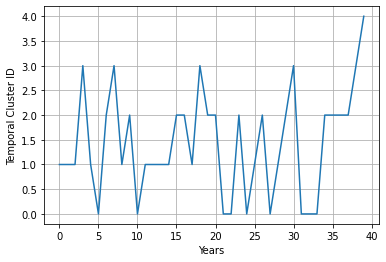

In [18]:
# Export Plots
# Temporal cluster
plt.plot(range(0,len(col_clusters)),col_clusters)
plt.grid(True)
plt.ylabel('Temporal Cluster ID')
plt.xlabel('Years')
plt.savefig((resultdir/(project_name+'_temporal_clusters')).as_posix())

### Visualization: spatial clusters

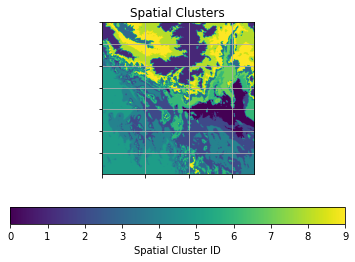

In [19]:
# Spatial cluster
h_tif = gdal.Open(dir_tiff.as_posix() +'/{}'.format(sorted(dir_tiff.glob(load_pattern))[0].name))
spatial_cl = np.empty(h_tif.RasterXSize*h_tif.RasterYSize)
spatial_cl[:] = np.nan
spatial_cl[mask] = row_clusters
spatial_cl = spatial_cl.reshape(h_tif.RasterYSize, h_tif.RasterXSize)

fig, ax = plt.subplots()
fig = ax.imshow(spatial_cl)
plt.title('Spatial Clusters')
ax.grid(True)
ax.set_xticklabels('')
ax.set_yticklabels('')
cbar = plt.colorbar(fig, orientation='horizontal')
cbar.set_label('Spatial Cluster ID')
plt.savefig((resultdir/(project_name+'_spatial_clusters')).as_posix())


### Visualization: group average per temporal cluster

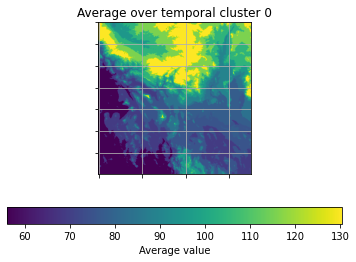

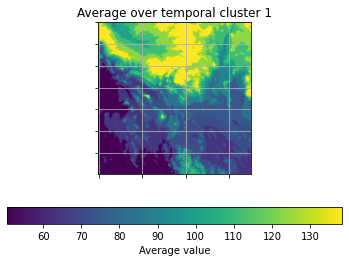

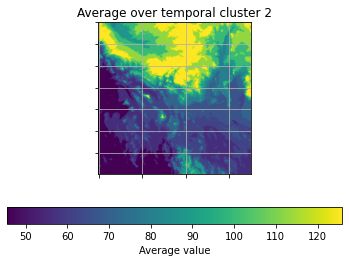

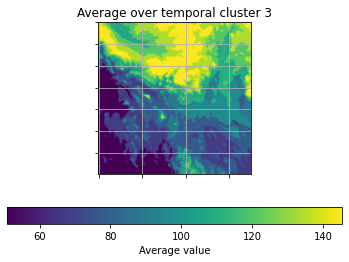

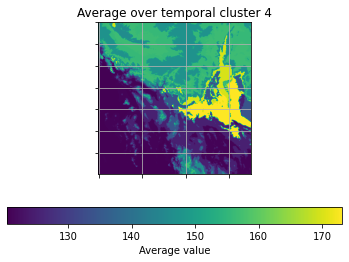

In [20]:
# Export Group average co-clustering
CoCavg = np.zeros((k, l)) 
row_idx = [np.argwhere(row_clusters == i).squeeze() for i in range(k)] 
col_idx = [np.argwhere(col_clusters == i).squeeze() for i in range(l)]     
for ir in range(k): 
    for ic in range(l): 
        r, c = np.meshgrid(row_idx[ir], col_idx[ic])
        # empty clusters won't be used - the actual num we use below does not matter
        CoCavg[ir, ic] = np.nan_to_num(Znp[r, c].mean())
        
for f in range(l):
    # Export png
    h_tif = gdal.Open(dir_tiff.as_posix() +'/{}'.format(sorted(dir_tiff.glob(load_pattern))[0].name))
    band_1 = np.empty(h_tif.RasterXSize*h_tif.RasterYSize)
    band_1[:] =  np.nan
    band_1[mask] = CoCavg[row_clusters, f]
    band_1 = band_1.reshape(h_tif.RasterYSize, h_tif.RasterXSize)
    fig, ax = plt.subplots()
    fig = ax.imshow(band_1)
    plt.title('Average over temporal cluster ' + str(f))
    ax.grid(True)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    cbar = plt.colorbar(fig, orientation='horizontal')
    cbar.set_label('Average value')
    fig = ax.imshow(band_1)
    plt.savefig((resultdir/(project_name+'_spatial_clusters_temp_clust_' + str(f))).as_posix())

### Visualization: K-means "mean" centroids per temporal cluster

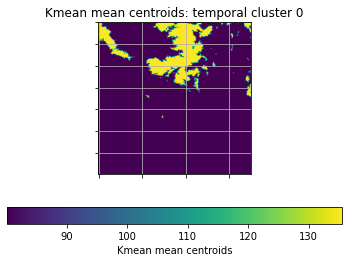

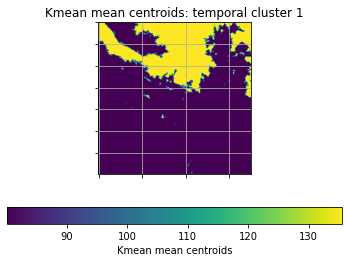

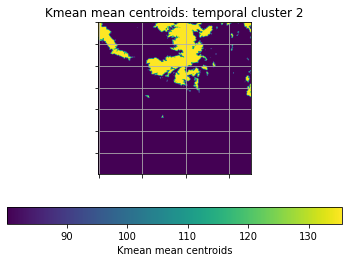

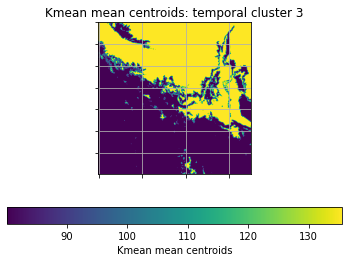

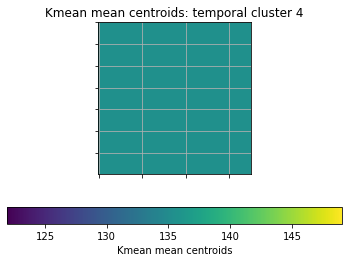

In [22]:
# Kmean visualization
for f in range(l):
    # Export png
    h_tif = gdal.Open(dir_tiff.as_posix() +'/{}'.format(sorted(dir_tiff.glob(load_pattern))[0].name))
    band_1 = np.empty(h_tif.RasterXSize*h_tif.RasterYSize)
    band_1[:] =  np.nan
    band_1[mask] = km.results.cl_mean_centroids[row_clusters, f]
    band_1 = band_1.reshape(h_tif.RasterYSize, h_tif.RasterXSize)
    fig, ax = plt.subplots()
    fig = ax.imshow(band_1)
    plt.title('Kmean mean centroids: temporal cluster ' + str(f))
    ax.grid(True)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    cbar = plt.colorbar(fig, orientation='horizontal')
    cbar.set_label('Kmean mean centroids')
    plt.savefig((resultdir/(project_name+'_kmean_spatial_clusters_temp_clust_' + str(f))).as_posix())